### The code is implemented and run on Google Colab

In [ ]:
# If use Google Colab, use the two commands to install torch and torchvision
!pip install torch
!pip install torchvision

In [ ]:
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load data
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
# load train and test data
X_train = train_dataset.data/255
y_train = np.array(train_dataset.targets)
X_test = test_dataset.data/255
y_test = np.array(test_dataset.targets)

In [ ]:
# vectorize train and test data
X_train = X_train.reshape((50000, 32*32*3))
X_test = X_test.reshape((10000, 32*32*3))

### Implementatation of K means

In [ ]:
# calculate eucildean distance
def eucli_distance(train_data, cluster_centres):
  dist_array = []
  #iterate train data and selected points
  for i in train_data:
    point_dist = []
    for j in cluster_centres:
      #calculate distance for each random point
      dist = np.linalg.norm((i-j))
      point_dist.append(dist)
    dist_array.append(point_dist)
  return dist_array


def get_clusters(distances):
  #find min distances from data points to centroids
  #use index as label for assigne clusters
  clusters=[]
  for i in distances:
    index_cluster = np.argmin(i)
    clusters.append(index_cluster)
  clusters = np.array(clusters)

  return clusters

def get_centroids(clusters,train_data,k):
  # get centroids for the next iteration
  centroids = []
  for i in range(k):
    # get all index(cluster numbers) of each data points and calculate means
    index = np.where(clusters==i)
    means = train_data[index].mean()
    centroids.append(means)

  centroids = np.array(centroids)

  return centroids

def k_means(train, k):
  #randomly pick k data points from train dataset
  index = np.random.choice(train.shape[0], k, replace=False) 
  random_centroids = train[index]
  
  #calculate distances
  distances = np.array(eucli_distance(train, random_centroids))

  #get clusters
  #find min distances from data points to centroids
  #use index as label for assigne clusters
  clusters = get_clusters(distances)

  #loop until centroids converge
  while(True):
    #get new centroids with clusters
    centroids = get_centroids(clusters,train,k)

    # repeat calculate distances
    distances = np.array(eucli_distance(train, centroids))

    #get new clusters with new distances
    clusters = get_clusters(distances)

    #get centroids for the next iteration
    next_centroids = get_centroids(clusters,train,k)

    #if centroids and next centroids are the same , then break loop
    subtractions = centroids - next_centroids
    if (np.all(subtractions==0)):
      break

  return clusters

# give predicted labels and true labels, find all differences
# calculate accruacy: #corrects/#total
def calculate_accuracy (predict_labels, true_labels):
    corrects = np.nonzero(predict_labels == true_labels)[0]
    accuracy = len(corrects)/len(true_labels)
    return accuracy


## calculate accuracy for different parameters in 5 fold cross validation

In [ ]:
# a list of parameters for k
k_li = [3,5,7,11]
total_acc_array = []

for k in k_li:
  acc_array = []
  final_predictions = np.zeros(40000)
  # train k means with 5 fold cross-validation
  # 5 fold cross-validation
  # split train dataset into 5 folds and iterate
  m = np.split(X_train,5)
  n = np.split(y_train,5)
  for index in range(5):
    #use index to split validations set and rest of train set
    if index == 0:
      trainset_x = np.concatenate(m[index+1:],axis=0)
      trainset_y  = np.concatenate(n[index+1:],axis=0)
    else:
      trainset_x =  np.concatenate(m[0:index]+m[index+1:],axis=0)
      trainset_y  = np.concatenate(n[0:index]+n[index+1:],axis=0)
    validation_x = m[index]
    validation_y = n[index]

    final_clusters = k_means(trainset_x, k)
    #assign the majority label in each cluster to all images in that cluster as the predicted label
    for i in range (k):
      #find clusters
      index = np.where(final_clusters==i)
      find_labels = trainset_y[index]
      #find majority label
      count_labels = np.bincount(find_labels)
      max_index = np.argmax(count_labels)
      final_predictions[index] = max_index
    acc = calculate_accuracy(final_predictions, trainset_y)
    acc_array.append(acc)
  total_acc_array.append(sum(acc_array)/len(acc_array))
  print("Average accuracy for k =" ,k,":", sum(acc_array)/len(acc_array)*100,"%")

Average accuracy for k = 3 : 15.655 %
Average accuracy for k = 5 : 15.72 %
Average accuracy for k = 7 : 16.0365 %
Average accuracy for k = 11 : 16.0325 %


## Draw a line graph with parameters as x-axis and accuracy as y-axis

Text(0.5, 1.0, 'Accuacy with different parameters')

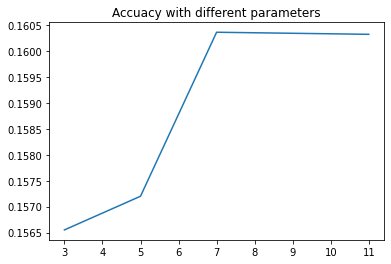

In [ ]:
plt.plot(k_li, total_acc_array)
plt.title('Accuacy with different parameters')

## Final accuracy with the best parameter

In [ ]:
k = 7
final_acc = []

final_clusters = k_means(X_test, k)
#assign the majority label in each cluster to all images in that cluster as the predicted label
final_predictions = np.zeros(10000)
for i in range (k):
  index = np.where(final_clusters==i)
  find_labels = y_test[index]
  count_labels = np.bincount(find_labels)
  max_index = np.argmax(count_labels)
  final_predictions[index] = max_index
acc = calculate_accuracy(final_predictions, y_test)
acc_array.append(acc)

In [ ]:
print("Average accuracy for k =" ,k,":", sum(acc_array)/len(acc_array)*100,"%")

Average accuracy for k = 7 : 16.081785714285715 %
